In [ ]:
# Checkout www.pygimli.org for more examples
%matplotlib inline


# 2D Refraction modeling and inversion

This example shows how to use the TravelTime manager to generate the response
of a three-layered sloping model and to invert the synthetic noisified data.


In [1]:
import numpy as np

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import TravelTimeManager

We start by creating a three-layered slope (The model is taken from the BSc
thesis of Constanze Reinken conducted at the University of Bonn).



(<AxesSubplot:>, None)

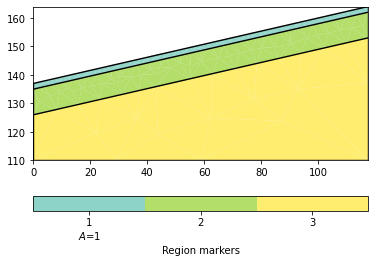

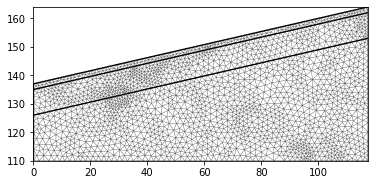

In [2]:
layer1 = mt.createPolygon([[0.0, 137], [117.5, 164], [117.5, 162], [0.0, 135]],
                          isClosed=True, marker=1, area=1)
layer2 = mt.createPolygon([[0.0, 126], [0.0, 135], [117.5, 162], [117.5, 153]],
                          isClosed=True, marker=2)
layer3 = mt.createPolygon([[0.0, 110], [0.0, 126], [117.5, 153], [117.5, 110]],
                          isClosed=True, marker=3)

slope = (164 - 137) / 117.5

geom = layer1 + layer2 + layer3

# If you want no sloped flat earth geometry .. comment out the next 2 lines
# geom = mt.createWorld(start=[0.0, 110], end=[117.5, 137], layers=[137-2, 137-11])
# slope = 0.0

pg.show(geom)

mesh = mt.createMesh(geom, quality=34.3, area=3, smooth=[1, 10])
pg.show(mesh)

Next we define geophone positions and a measurement scheme, which consists of
shot and receiver indices.



In [3]:
numberGeophones = 48
sensors = np.linspace(0., 117.5, numberGeophones)
scheme = pg.physics.traveltime.createRAData(sensors)

# Adapt sensor positions to slope
pos = np.array(scheme.sensors())
for x in pos[:, 0]:
    i = np.where(pos[:, 0] == x)
    new_y = x * slope + 137
    pos[i, 1] = new_y

scheme.setSensors(pos)

Now we initialize the TravelTime manager and asssign P-wave velocities to the
layers. To this end, we create a map from cell markers 0 through 3 to
velocities (in m/s) and generate a velocity vector. To check whether the
model looks correct, we plot it along with the sensor positions.



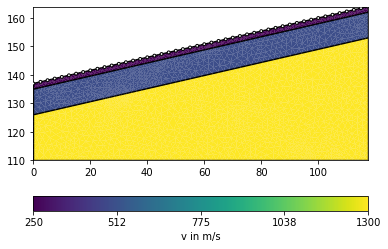

In [4]:
mgr = TravelTimeManager()
vp = np.array(mesh.cellMarkers())
vp[vp == 1] = 250
vp[vp == 2] = 500
vp[vp == 3] = 1300

ax, _ = pg.show(mesh, vp, colorBar=True, logScale=False, label='v in m/s')
pg.viewer.mpl.drawSensors(ax, scheme.sensors(), diam=1.0,
                         facecolor='white', edgecolor='black')

We use this model to create noisified synthetic data and look at the
traveltime data matrix. Note, we force a specific noise seed as we want
reproducable results for testing purposes.
TODO: show first arrival traveltime curves.



10/08/22 - 01:46:58 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.


1

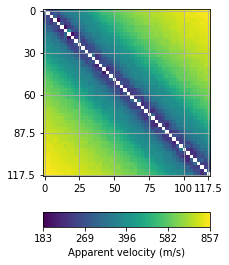

In [5]:
data = mgr.simulate(slowness=1.0 / vp, scheme=scheme, mesh=mesh,
                    noiseLevel=0.001, noiseAbs=0.001, seed=1337,
                    verbose=True)
mgr.showData(data)

Now we invert the synthetic data. We need a new independent mesh without
information about the layered structure. This mesh can be created manual or
guessd automatic from the data sensor positions (in this example). We
tune the maximum cell size in the parametric domain to 15m²



In [ ]:
vest = mgr.invert(data, secNodes=2, paraMaxCellSize=15.0,
                  maxIter=10, verbose=True)
np.testing.assert_array_less(mgr.inv.inv.chi2(), 1.1)

The manager also holds the method showResult that is used to plot the result.
Note that only covered cells are shown by default.
For comparison we plot the geometry on top.



In [ ]:
ax, _ = mgr.showResult(cMin=min(vp), cMax=max(vp), logScale=False)
pg.show(geom, ax=ax, fillRegion=False, regionMarker=False)

Note that internally the following is called

.. code-block:: python

   ax, _ = pg.show(ra.mesh, vest, label="Velocity [m/s]", **kwargs)




Another useful method is to show the model along with its response
on the data.



In [ ]:
mgr.showResultAndFit(cMin=min(vp), cMax=max(vp))

<div class="alert alert-info"><h4>Note</h4><p>Takeaway message</p></div>



In [ ]:
#     A default data inversion with checking of the data consists of only few
#     lines. Check out :ref:`ex:koenigsee`.